In [ ]:
!unzip dataset_5000samples.zip

Archive:  dataset_5000samples.zip
replace dataset_5000samples/clusters.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace dataset_5000samples/meth.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace dataset_5000samples/mRNA.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace dataset_5000samples/prot.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: no


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, Conv1D, MaxPooling1D, UpSampling1D

# GAN for mRNA samples generation

## The model

In [ ]:
"""
BIOINFORMATICS: LAB07
@author: Irene Benedetto
"""

import tensorflow as tf

# create the discriminator model
class Discriminator(tf.keras.Model):
    """
        This class constitute simple implemtation of a Discriminator model in
        a Generative Adversarial Network. This model seeks to determine if a
        image is generated artificially or comes from the real dataset.

    """

    def __init__(self, input_shape, output_shape):
        super(Discriminator, self).__init__()

        self.conv1 = tf.keras.layers.Conv1D(32, 3, strides=2, padding='same', input_shape=input_shape)
        self.relu1 = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.conv2 = tf.keras.layers.Conv1D(64, 3, padding='same')
        self.relu2 = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.max_pool = tf.keras.layers.GlobalMaxPooling1D()
        self.dense = tf.keras.layers.Dense(output_shape)
        self.compiled_loss = None
        self.optimizer = None
        self.compiled_metrics = None

    def compile(self, loss, optimizer, metrics):
        self.compiled_loss = loss
        self.optimizer = optimizer
        self.compiled_metrics = metrics

    def __call__(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.max_pool(x)
        x = self.dense(x)
        return x

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            # Compute the loss value
            loss = self.compiled_loss(y, y_pred)

        trainable_params = []
        for layer in [self.conv1, self.conv2, self.dense]:
            for param in layer.trainable_weights:
                trainable_params.append(param)

        gradients = tape.gradient(loss, trainable_params)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_params))
        # Update metrics
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {'loss': loss, 'accuracy': self.compiled_metrics.result().numpy()}


class Generator(tf.keras.Model):
    """
        This class constitute simple implementation of a Generator model in
        a Generative Adversarial Network. This model is trained to create new images
        starting from a random noise vector of dimension = latent_dim.
    """

    def __init__(self, latent_dim, output_shape):
        super(Generator, self).__init__()

        self.fc = tf.keras.layers.Dense(128, input_dim=latent_dim)
        self.relu1 = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.reshape = tf.keras.layers.Reshape((1, 128))

        self.conv1 = tf.keras.layers.Conv1DTranspose(64, 4, strides=1, padding="same")
        self.relu2 = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.dense = tf.keras.layers.Dense(output_shape[-1])

        self.compiled_loss = None
        self.optimizer = None
        self.compiled_metrics = None

    def compile(self, loss, optimizer, metrics):
        self.compiled_loss = loss
        self.optimizer = optimizer
        self.compiled_metrics = metrics
        
    def __call__(self, x):
        x = self.fc(x)
        x = self.relu1(x)
        x = self.reshape(x)
        x = self.conv1(x)
        x = self.relu2(x)
        x = self.dense(x)
        return x

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            # Compute the loss value
            loss = self.compiled_loss(y, y_pred)

        trainable_params = []
        for layer in [self.fc, self.conv1, self.conv2, self.conv3]:
            for param in layer.trainable_weights:
                trainable_params.append(param)

        gradients = tape.gradient(loss, trainable_params)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_params))
        # Update metrics
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {'loss': loss, 'accuracy': self.compiled_metrics.result().numpy()}


class GAN(tf.keras.Model):
    def __init__(self, generator, discriminator, latent_dim, BATCH_SIZE):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.BATCH_SIZE = BATCH_SIZE

        self.compiled_loss = None
        self.d_optimizer = None
        self.g_optimizer = None
        self.gan_metrics = None

    def compile(self, loss, d_optimizer, g_optimizer, metrics):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss

    def train_step(self, real_data):
        (real_img, _) = real_data
        n_images = len(real_img)

        # label 1 means fake
        # label 0 means true

        # create random noise and fake images
        rand_noise = tf.random.normal(shape=(self.BATCH_SIZE, self.latent_dim), dtype=tf.float32)
        fake_img = self.generator(rand_noise)
        real_img = tf.cast(real_img, dtype=tf.float32)
        
        # Combine them with real images
        images = tf.concat([fake_img, real_img], axis=0)

        y = tf.concat([tf.ones((self.BATCH_SIZE, 1)), tf.zeros((n_images, 1))], axis=0)
        # Add random noise to the labels - important trick!
        y += 0.05 * tf.random.uniform(tf.shape(y))

        # Train the discriminator
        with tf.GradientTape() as tape:
            y_pred = self.discriminator(images)
            discriminator_loss = self.loss_fn(y, y_pred)

        grads = tape.gradient(discriminator_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample again new random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(self.BATCH_SIZE, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((self.BATCH_SIZE, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator): it is trained to confuse!
        with tf.GradientTape() as tape:
            y_pred = self.discriminator(self.generator(random_latent_vectors))
            generator_loss = self.loss_fn(misleading_labels, y_pred)

        grads = tape.gradient(generator_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"discriminator_loss": discriminator_loss, "generator_loss": generator_loss}



In [ ]:
mrna_df = pd.read_csv('./dataset_5000samples/mRNA.txt', sep='\t')
meth_df = pd.read_csv('./dataset_5000samples/meth.txt', sep='\t')
prot_df = pd.read_csv('./dataset_5000samples/prot.txt', sep='\t')

mrna_df = mrna_df.set_index('probe').T
meth_df = meth_df.set_index('probe').T
prot_df = prot_df.set_index('probe').T

labels = pd.read_csv('./dataset_5000samples/clusters.txt', sep='\t')
labels = labels.set_index('subjects')
mrna_df.head()

probe,ACACA,ACVRL1,AKT1,AKT1S1,ANXA1,AR,ARAF,ASNS,ATM,BAD,BAK1,BAP1,BAX,BCL2,BCL2L1,BCL2L11,BECN1,BID,BRAF,BRCA2,CASP7,CAV1,CCNB1,CCND1,CCNE1,CCNE2,CDH1,CDH2,CDH3,CDKN1A,CDKN1B,CHEK1,CHEK2,CLDN7,COL6A1,CTNNB1,DIRAS3,DVL3,EEF2,EEF2K,...,PTEN,PXN,RAB25,RAD50,RAD51,RAF1,RB1,RBM15,RPS6,RPS6KA1,RPS6KB1,SERPINE1,SFRS1,SHC1,SMAD1,SMAD3,SMAD4,SQSTM1,SRC,STAT3,STAT5A,STK11,STMN1,SYK,TGM2,TP53,TP53BP1,TSC1,TSC2,TUBA1B,VHL,WWTR1,XBP1,XRCC1,XRCC5,YAP1,YBX1,YWHAB,YWHAE,YWHAZ
subject1,-0.202976,3.824083,1.941961,1.892566,-0.944976,4.025588,1.931352,1.818177,1.356862,3.545808,2.993446,1.850183,2.738257,1.612507,1.024410,1.133878,1.894619,1.367329,3.980014,1.124177,0.830144,0.942295,-0.879421,0.896102,4.182551,3.252804,4.288507,3.237370,4.743553,0.991820,0.736323,2.931491,3.411393,4.336482,-0.172762,1.042420,2.658989,1.215174,-1.560762,-0.214732,...,2.952053,-0.479884,0.654347,2.184739,-0.169622,-0.002187,1.213495,-0.071032,1.255225,-1.002202,0.787247,0.216932,2.593745,1.744951,4.468721,0.248531,1.854355,1.758628,1.338441,3.346318,2.094348,1.939623,3.185947,4.198166,1.846847,1.965210,0.439563,0.102336,0.543139,-0.329378,3.032120,1.746216,1.928091,3.003348,0.259629,4.406141,0.252923,0.094568,3.759704,1.590642
subject2,1.641256,1.155427,-1.662717,1.251313,1.425577,2.736461,1.826906,0.249232,-0.035702,3.055626,0.842203,-1.196114,2.190861,1.188179,0.616593,0.765032,-0.171708,2.421508,4.145598,-0.360031,4.025167,-0.637182,0.470162,0.842170,3.178562,-0.194919,3.143534,2.237001,3.758940,0.687560,0.136228,0.464420,2.792323,2.918892,0.085349,3.727336,4.568028,4.265223,-1.242302,0.294680,...,0.451298,-0.123341,0.969371,-0.671016,-1.271249,2.477107,1.897999,2.229601,0.778705,-0.511495,0.178932,-2.142783,-0.832622,-0.322831,1.455057,-0.855356,2.738722,2.421207,2.528709,3.280261,-0.712507,1.854717,1.788465,5.335390,-0.120486,2.478598,3.020251,-0.875561,0.097303,-0.674101,3.372553,0.535820,2.643599,0.180999,0.459260,4.320906,0.636707,0.007298,3.181769,0.285204
subject3,-1.012489,3.843859,1.022982,1.451110,3.376559,4.987415,-1.509674,0.841377,2.316144,3.376270,2.705328,1.061179,-0.743559,5.496075,2.654845,1.694023,-0.063691,1.833665,3.701334,2.352961,1.412985,-1.053752,1.439258,1.576354,3.090763,-1.188771,5.868547,1.455604,3.189403,2.115154,4.051566,-1.460585,2.402294,2.659873,1.355472,4.439125,4.910748,3.215977,1.416086,3.331378,...,3.956887,-0.164761,0.197531,3.145125,1.725533,2.974045,1.780950,1.579057,1.393796,2.360494,-1.275129,1.257240,-0.255249,1.686507,1.129267,-0.762574,4.164212,3.773788,-0.309753,3.649911,2.296399,2.131777,2.046682,5.164825,0.809981,-1.246060,2.094257,-0.296498,0.133941,1.880346,2.401812,0.742165,1.831689,0.151429,2.988180,1.109919,-1.163853,0.578840,2.033397,2.720514
subject4,2.368667,1.589550,-1.561386,1.541984,2.325147,2.519527,1.534221,1.344263,-1.710746,3.076983,1.324401,-1.664112,2.820801,3.790010,1.066259,0.232580,-0.135074,2.577970,3.732496,0.268579,3.304332,0.715474,1.609099,1.137539,3.385303,0.965255,3.269998,-0.956341,5.157696,3.536281,0.301627,1.186099,2.342919,2.860937,1.244460,2.823257,5.197140,2.621826,-1.983947,-0.065952,...,1.491611,-0.238383,4.032395,-0.407355,-1.380884,3.193258,1.009249,1.745447,0.952362,0.028222,1.355767,-1.148589,-0.392060,-0.413171,2.124812,-0.038943,1.642974,2.068791,3.270798,2.980493,-0.681469,2.331594,2.604402,5.829168,0.252591,1.062846,3.200149,-0.662072,0.696254,-0.149613,2.824883,0.548850,0.837038,1.390423,0.218031,3.000870,-1.214967,-0.553528,3.221076,0.295506
subject5,1.499256,1.387675,-0.407935,1.838693,0.169267,2.822129,2.233880,1.341976,-0.274837,2.737312,1.684850,-0.452958,2.324203,1.111010,0.991468,0.599265,-0.601411,3.229009,3.834429,-1.013886,3.351466,-0.686813,1.103573,1.078431,1.322370,2.065173,3.518887,2.929057,4.680377,0.454712,0.048949,2.750354,3.134901,2.872708,-1.005160,2.969760,1.419982,3.614087,-0.754464,0.296020,...,0.628002,-0.401949,-0.152019,0.357040,-0.387627,2.018984,0.936235,2.534884,1.559044,-0.619607,1.623437,-0.764262,-0.459446,-1.226866,1.061712,-0.400974,3.

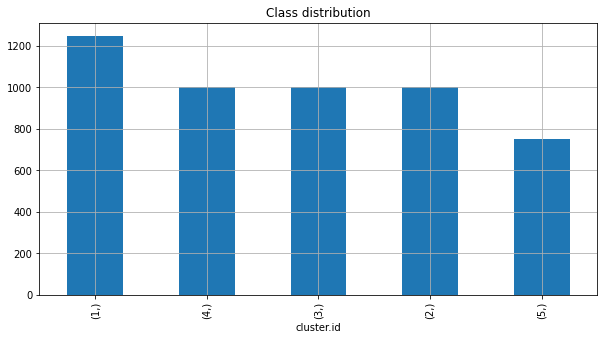

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Class distribution')
labels.value_counts().plot.bar('count')
plt.grid()
plt.show()

# number of synthetic examples  to generate for each class
n_synthetic_samples = np.max(labels.value_counts().values) - labels.value_counts().values 

In [ ]:
N_EPOCHS = 20
BATCH_SIZE = 64

gan_synthetic_samples = {}

for i, n_synthetic_samples in enumerate(n_synthetic_samples):
    print(f"Required {n_synthetic_samples} samples for class {i+1}")

    if n_synthetic_samples == 0:
        continue

    df_class = mrna_df.loc[labels['cluster.id'] == i+1]
    train_ds = tf.data.Dataset.from_tensor_slices((df_class.values, df_class.values))

    train_ds = train_ds.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(BATCH_SIZE)
    train_ds = train_ds.map(lambda x, y: (tf.expand_dims(x, 1), tf.expand_dims(y, 1)))

    latent_dim = 128
    for x, y in train_ds:
        input_shape = x.shape.as_list()[1:]
        output_shape = y.shape.as_list()[1:]
        print(f'Training set: {input_shape}')
        break

    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    d_metrics = tf.keras.metrics.SparseCategoricalAccuracy(name='discriminator_accuracy')
    g_metrics = tf.keras.metrics.SparseCategoricalAccuracy(name='generator_accuracy')
    metrics = tf.keras.metrics.SparseCategoricalAccuracy(name='gan_accuracy')

    g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
    d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)

    discriminator = Discriminator(input_shape=input_shape + [1], output_shape=1)
    discriminator.compile(loss, d_optimizer, d_metrics)
    generator = Generator(latent_dim=latent_dim, output_shape=output_shape)
    generator.compile(loss, g_optimizer, g_metrics)
    gan = GAN(generator=generator, discriminator=discriminator, latent_dim=latent_dim, BATCH_SIZE=BATCH_SIZE)

    gan.compile(loss, d_optimizer, g_optimizer, metrics)

    for epoch in range(N_EPOCHS):

        losses = {"discriminator_loss": 0, "generator_loss": 0}
        print(f'Epoch {epoch + 1}/{N_EPOCHS}')
        for x, y in tqdm(train_ds):
            history = gan.train_step((x, y))
            losses['discriminator_loss'] += history['discriminator_loss']
            losses['generator_loss'] += history['generator_loss']

        print(f"Discriminator loss: {losses['discriminator_loss']}")
        print(f"Generator loss: {losses['generator_loss']}")

    
    gan_synthetic_samples[i+1] = []
    for _ in range(n_synthetic_samples):
        random_latent_vectors = tf.random.normal(shape=(1, latent_dim))
        generated_images = gan.generator(random_latent_vectors)
        gan_synthetic_samples[i+1].append(generated_images[0][0])


    

 19%|█▉        | 3/16 [00:00<00:00, 27.00it/s]

Required 0 samples for class 1
Required 250 samples for class 2
Training set: [1, 131]
Epoch 1/20


 25%|██▌       | 4/16 [00:00<00:00, 36.98it/s]

Discriminator loss: 12.066006660461426
Generator loss: 10.3692626953125
Epoch 2/20


 25%|██▌       | 4/16 [00:00<00:00, 35.94it/s]

Discriminator loss: 9.29465103149414
Generator loss: 9.263029098510742
Epoch 3/20


 19%|█▉        | 3/16 [00:00<00:00, 27.93it/s]

Discriminator loss: 8.401301383972168
Generator loss: 9.1045503616333
Epoch 4/20


 25%|██▌       | 4/16 [00:00<00:00, 34.13it/s]

Discriminator loss: 7.679079055786133
Generator loss: 10.152334213256836
Epoch 5/20


 19%|█▉        | 3/16 [00:00<00:00, 29.45it/s]

Discriminator loss: 6.8282670974731445
Generator loss: 12.063704490661621
Epoch 6/20


 19%|█▉        | 3/16 [00:00<00:00, 29.61it/s]

Discriminator loss: 5.9135966300964355
Generator loss: 14.050636291503906
Epoch 7/20


 25%|██▌       | 4/16 [00:00<00:00, 35.11it/s]

Discriminator loss: 5.839156150817871
Generator loss: 14.172439575195312
Epoch 8/20


 25%|██▌       | 4/16 [00:00<00:00, 36.58it/s]

Discriminator loss: 6.142003536224365
Generator loss: 13.143924713134766
Epoch 9/20


 25%|██▌       | 4/16 [00:00<00:00, 32.37it/s]

Discriminator loss: 6.315598487854004
Generator loss: 12.94009017944336
Epoch 10/20


 25%|██▌       | 4/16 [00:00<00:00, 32.38it/s]

Discriminator loss: 5.357290267944336
Generator loss: 15.560826301574707
Epoch 11/20


 25%|██▌       | 4/16 [00:00<00:00, 33.20it/s]

Discriminator loss: 4.561539649963379
Generator loss: 18.135610580444336
Epoch 12/20


 25%|██▌       | 4/16 [00:00<00:00, 31.45it/s]

Discriminator loss: 5.632777214050293
Generator loss: 15.302475929260254
Epoch 13/20


 25%|██▌       | 4/16 [00:00<00:00, 33.48it/s]

Discriminator loss: 6.698855400085449
Generator loss: 13.109339714050293
Epoch 14/20


 25%|██▌       | 4/16 [00:00<00:00, 37.82it/s]

Discriminator loss: 4.677929401397705
Generator loss: 20.02478790283203
Epoch 15/20


 25%|██▌       | 4/16 [00:00<00:00, 33.10it/s]

Discriminator loss: 2.667933702468872
Generator loss: 28.071765899658203
Epoch 16/20


 25%|██▌       | 4/16 [00:00<00:00, 37.15it/s]

Discriminator loss: 4.059504985809326
Generator loss: 20.774263381958008
Epoch 17/20


 25%|██▌       | 4/16 [00:00<00:00, 36.77it/s]

Discriminator loss: 6.629969120025635
Generator loss: 13.937650680541992
Epoch 18/20


 25%|██▌       | 4/16 [00:00<00:00, 35.45it/s]

Discriminator loss: 6.877416610717773
Generator loss: 13.979177474975586
Epoch 19/20


 25%|██▌       | 4/16 [00:00<00:00, 32.44it/s]

Discriminator loss: 4.8924126625061035
Generator loss: 19.82501792907715
Epoch 20/20


100%|██████████| 16/16 [00:00<00:00, 33.72it/s]


Discriminator loss: 5.033368110656738
Generator loss: 20.86590003967285


 19%|█▉        | 3/16 [00:00<00:00, 26.64it/s]

Required 250 samples for class 3
Training set: [1, 131]
Epoch 1/20


 25%|██▌       | 4/16 [00:00<00:00, 36.47it/s]

Discriminator loss: 8.56279182434082
Generator loss: 10.256575584411621
Epoch 2/20


 25%|██▌       | 4/16 [00:00<00:00, 36.19it/s]

Discriminator loss: 7.982053756713867
Generator loss: 9.070911407470703
Epoch 3/20


 25%|██▌       | 4/16 [00:00<00:00, 32.03it/s]

Discriminator loss: 7.921103477478027
Generator loss: 9.262899398803711
Epoch 4/20


 25%|██▌       | 4/16 [00:00<00:00, 32.89it/s]

Discriminator loss: 6.699291229248047
Generator loss: 11.724336624145508
Epoch 5/20


 25%|██▌       | 4/16 [00:00<00:00, 36.66it/s]

Discriminator loss: 5.6729326248168945
Generator loss: 14.43107795715332
Epoch 6/20


 25%|██▌       | 4/16 [00:00<00:00, 38.64it/s]

Discriminator loss: 7.467397212982178
Generator loss: 11.439417839050293
Epoch 7/20


 19%|█▉        | 3/16 [00:00<00:00, 28.80it/s]

Discriminator loss: 8.726286888122559
Generator loss: 9.708486557006836
Epoch 8/20


 25%|██▌       | 4/16 [00:00<00:00, 38.25it/s]

Discriminator loss: 8.06832218170166
Generator loss: 10.830063819885254
Epoch 9/20


 25%|██▌       | 4/16 [00:00<00:00, 31.93it/s]

Discriminator loss: 6.396162986755371
Generator loss: 13.720226287841797
Epoch 10/20


 25%|██▌       | 4/16 [00:00<00:00, 37.50it/s]

Discriminator loss: 4.862915515899658
Generator loss: 17.640695571899414
Epoch 11/20


 25%|██▌       | 4/16 [00:00<00:00, 37.16it/s]

Discriminator loss: 5.427967548370361
Generator loss: 16.855060577392578
Epoch 12/20


 25%|██▌       | 4/16 [00:00<00:00, 32.14it/s]

Discriminator loss: 7.159916400909424
Generator loss: 13.63218879699707
Epoch 13/20


 25%|██▌       | 4/16 [00:00<00:00, 32.80it/s]

Discriminator loss: 6.456037521362305
Generator loss: 15.431686401367188
Epoch 14/20


 25%|██▌       | 4/16 [00:00<00:00, 33.07it/s]

Discriminator loss: 3.607401132583618
Generator loss: 24.665603637695312
Epoch 15/20


 25%|██▌       | 4/16 [00:00<00:00, 32.14it/s]

Discriminator loss: 2.8925371170043945
Generator loss: 29.856082916259766
Epoch 16/20


 25%|██▌       | 4/16 [00:00<00:00, 37.10it/s]

Discriminator loss: 3.9077112674713135
Generator loss: 26.579139709472656
Epoch 17/20


 25%|██▌       | 4/16 [00:00<00:00, 38.26it/s]

Discriminator loss: 6.1287055015563965
Generator loss: 21.66294288635254
Epoch 18/20


 25%|██▌       | 4/16 [00:00<00:00, 36.11it/s]

Discriminator loss: 7.779845237731934
Generator loss: 17.65700912475586
Epoch 19/20


 25%|██▌       | 4/16 [00:00<00:00, 32.54it/s]

Discriminator loss: 2.834826707839966
Generator loss: 33.1792106628418
Epoch 20/20


100%|██████████| 16/16 [00:00<00:00, 34.21it/s]


Discriminator loss: 3.072307586669922
Generator loss: 31.409385681152344


 12%|█▎        | 2/16 [00:00<00:00, 19.94it/s]

Required 250 samples for class 4
Training set: [1, 131]
Epoch 1/20


 25%|██▌       | 4/16 [00:00<00:00, 35.68it/s]

Discriminator loss: 8.171318054199219
Generator loss: 10.508877754211426
Epoch 2/20


 25%|██▌       | 4/16 [00:00<00:00, 37.88it/s]

Discriminator loss: 8.13205337524414
Generator loss: 8.842964172363281
Epoch 3/20


 25%|██▌       | 4/16 [00:00<00:00, 34.14it/s]

Discriminator loss: 8.952958106994629
Generator loss: 7.94316291809082
Epoch 4/20


 25%|██▌       | 4/16 [00:00<00:00, 38.32it/s]

Discriminator loss: 8.292871475219727
Generator loss: 9.321327209472656
Epoch 5/20


 25%|██▌       | 4/16 [00:00<00:00, 34.58it/s]

Discriminator loss: 6.209147930145264
Generator loss: 13.330418586730957
Epoch 6/20


 25%|██▌       | 4/16 [00:00<00:00, 37.87it/s]

Discriminator loss: 5.382169723510742
Generator loss: 15.367241859436035
Epoch 7/20


 25%|██▌       | 4/16 [00:00<00:00, 36.43it/s]

Discriminator loss: 5.480956077575684
Generator loss: 14.785717010498047
Epoch 8/20


 25%|██▌       | 4/16 [00:00<00:00, 38.54it/s]

Discriminator loss: 5.024039268493652
Generator loss: 15.595610618591309
Epoch 9/20


 25%|██▌       | 4/16 [00:00<00:00, 38.79it/s]

Discriminator loss: 4.558517932891846
Generator loss: 16.70046615600586
Epoch 10/20


 25%|██▌       | 4/16 [00:00<00:00, 35.77it/s]

Discriminator loss: 4.826997756958008
Generator loss: 16.320478439331055
Epoch 11/20


 25%|██▌       | 4/16 [00:00<00:00, 38.22it/s]

Discriminator loss: 5.692491054534912
Generator loss: 14.185385704040527
Epoch 12/20


 25%|██▌       | 4/16 [00:00<00:00, 37.57it/s]

Discriminator loss: 5.3032755851745605
Generator loss: 15.186118125915527
Epoch 13/20


 19%|█▉        | 3/16 [00:00<00:00, 28.81it/s]

Discriminator loss: 5.987177848815918
Generator loss: 13.719955444335938
Epoch 14/20


 25%|██▌       | 4/16 [00:00<00:00, 32.17it/s]

Discriminator loss: 7.383150100708008
Generator loss: 11.081442832946777
Epoch 15/20


 25%|██▌       | 4/16 [00:00<00:00, 32.38it/s]

Discriminator loss: 5.597472190856934
Generator loss: 14.98188591003418
Epoch 16/20


 25%|██▌       | 4/16 [00:00<00:00, 32.62it/s]

Discriminator loss: 2.959669828414917
Generator loss: 25.157936096191406
Epoch 17/20


 19%|█▉        | 3/16 [00:00<00:00, 29.96it/s]

Discriminator loss: 2.291417121887207
Generator loss: 29.550098419189453
Epoch 18/20


 25%|██▌       | 4/16 [00:00<00:00, 38.73it/s]

Discriminator loss: 2.775219440460205
Generator loss: 25.738147735595703
Epoch 19/20


 25%|██▌       | 4/16 [00:00<00:00, 36.80it/s]

Discriminator loss: 3.624959707260132
Generator loss: 21.852378845214844
Epoch 20/20


100%|██████████| 16/16 [00:00<00:00, 36.56it/s]


Discriminator loss: 4.5174055099487305
Generator loss: 18.74945068359375


 25%|██▌       | 3/12 [00:00<00:00, 26.10it/s]

Required 500 samples for class 5
Training set: [1, 131]
Epoch 1/20


 33%|███▎      | 4/12 [00:00<00:00, 39.30it/s]

Discriminator loss: 6.23289680480957
Generator loss: 7.719093322753906
Epoch 2/20


 33%|███▎      | 4/12 [00:00<00:00, 39.61it/s]

Discriminator loss: 5.931333065032959
Generator loss: 6.915455341339111
Epoch 3/20


 33%|███▎      | 4/12 [00:00<00:00, 33.08it/s]

Discriminator loss: 6.1475067138671875
Generator loss: 6.55601692199707
Epoch 4/20


 33%|███▎      | 4/12 [00:00<00:00, 35.63it/s]

Discriminator loss: 6.017820358276367
Generator loss: 6.815973281860352
Epoch 5/20


 33%|███▎      | 4/12 [00:00<00:00, 35.61it/s]

Discriminator loss: 5.487521171569824
Generator loss: 7.654427528381348
Epoch 6/20


 33%|███▎      | 4/12 [00:00<00:00, 37.12it/s]

Discriminator loss: 4.985977649688721
Generator loss: 8.763718605041504
Epoch 7/20


 33%|███▎      | 4/12 [00:00<00:00, 32.00it/s]

Discriminator loss: 4.758943557739258
Generator loss: 9.521261215209961
Epoch 8/20


 33%|███▎      | 4/12 [00:00<00:00, 32.80it/s]

Discriminator loss: 5.129029750823975
Generator loss: 9.021727561950684
Epoch 9/20


 33%|███▎      | 4/12 [00:00<00:00, 33.21it/s]

Discriminator loss: 5.321367263793945
Generator loss: 8.663819313049316
Epoch 10/20


 33%|███▎      | 4/12 [00:00<00:00, 33.30it/s]

Discriminator loss: 4.825630187988281
Generator loss: 9.613792419433594
Epoch 11/20


 33%|███▎      | 4/12 [00:00<00:00, 32.75it/s]

Discriminator loss: 4.4411163330078125
Generator loss: 10.548213958740234
Epoch 12/20


 33%|███▎      | 4/12 [00:00<00:00, 32.63it/s]

Discriminator loss: 4.7336626052856445
Generator loss: 9.975881576538086
Epoch 13/20


 33%|███▎      | 4/12 [00:00<00:00, 35.44it/s]

Discriminator loss: 4.927951812744141
Generator loss: 9.727997779846191
Epoch 14/20


 33%|███▎      | 4/12 [00:00<00:00, 37.97it/s]

Discriminator loss: 4.926181793212891
Generator loss: 9.982851028442383
Epoch 15/20


 33%|███▎      | 4/12 [00:00<00:00, 37.73it/s]

Discriminator loss: 5.111299991607666
Generator loss: 9.560700416564941
Epoch 16/20


 33%|███▎      | 4/12 [00:00<00:00, 39.17it/s]

Discriminator loss: 4.786114692687988
Generator loss: 10.46245288848877
Epoch 17/20


 33%|███▎      | 4/12 [00:00<00:00, 38.45it/s]

Discriminator loss: 3.680418014526367
Generator loss: 13.49679946899414
Epoch 18/20


 25%|██▌       | 3/12 [00:00<00:00, 29.78it/s]

Discriminator loss: 2.56968355178833
Generator loss: 18.17877197265625
Epoch 19/20


 33%|███▎      | 4/12 [00:00<00:00, 38.34it/s]

Discriminator loss: 2.3508450984954834
Generator loss: 19.799558639526367
Epoch 20/20


100%|██████████| 12/12 [00:00<00:00, 36.11it/s]


Discriminator loss: 2.8097050189971924
Generator loss: 18.181394577026367


In [ ]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
ds_smote, labels_smote = oversample.fit_resample(mrna_df.values, labels.values)

smote_synthetic_samples = {}
for synthetic_sample, label in zip(ds_smote[5000:], labels_smote[5000:]):
    if label not in smote_synthetic_samples.keys():
        smote_synthetic_samples[label] = []
    
    smote_synthetic_samples[label].append(synthetic_sample)
    

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=F

	Class 2
P-value of the test between orignal and SMOTE population 0.5799385187041434
Orignal and SMOTE population have different distributions

P-value of the test between orignal and GAN population 0.017996403265373558
Orignal and GAN population have different distributions

	Class 3
P-value of the test between orignal and SMOTE population 0.5168263186932777
Orignal and SMOTE population have different distributions

P-value of the test between orignal and GAN population 0.020747793764220042
Orignal and GAN population have different distributions

	Class 4
P-value of the test between orignal and SMOTE population 0.4670344745026936
Orignal and SMOTE population have different distributions

P-value of the test between orignal and GAN population 0.011101099325268746
Orignal and GAN population have different distributions

	Class 5
P-value of the test between orignal and SMOTE population 0.6250336136388249
Orignal and SMOTE population have different distributions

P-value of the test betwe

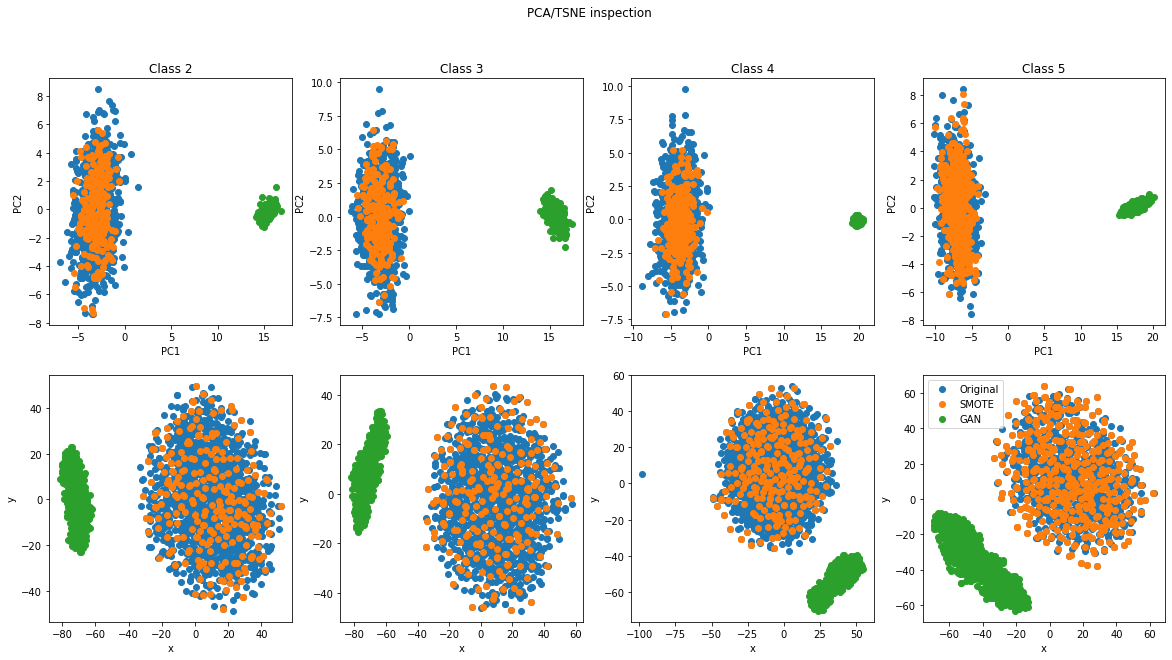

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import ttest_ind


figs, axs = plt.subplots(2, 4, figsize=(20, 10))
plt.suptitle('PCA/TSNE inspection')
i = 0
for label in smote_synthetic_samples.keys():

    original_samples = mrna_df.loc[labels['cluster.id'] == label]

    all_samples = np.concatenate([mrna_df.loc[labels['cluster.id'] == label].values, np.array(smote_synthetic_samples[label]), np.array(gan_synthetic_samples[label])])
    n_original = len(mrna_df.loc[labels['cluster.id'] == label].values)
    n_smote = len(np.array(smote_synthetic_samples[label]))
    n_gan = len(np.array(gan_synthetic_samples[label]))

    pca = PCA(n_components=2)
    pca.fit(all_samples)

    original_samples = pca.transform(original_samples)
    smote_samples = pca.transform(smote_synthetic_samples[label])
    gan_samples = pca.transform(gan_synthetic_samples[label])

    axs[0, i].set_title(f'Class {label}')
    axs[0, i].scatter(original_samples[:, 0], original_samples[:, 1], label='Original')
    axs[0, i].scatter(smote_samples[:, 0], smote_samples[:, 1], label='SMOTE')
    axs[0, i].scatter(gan_samples[:, 0], gan_samples[:, 1], label='GAN')
    axs[0, i].set_xlabel('PC1')
    axs[0, i].set_ylabel('PC2')

    tsne = TSNE(n_components=2)
    
    tsne_samples = tsne.fit_transform(all_samples)

    original_samples = tsne_samples[:n_original]
    smote_samples = tsne_samples[n_original:(n_original+n_smote)]
    gan_samples = tsne_samples[-n_gan:]

    axs[1, i].scatter(original_samples[:, 0], original_samples[:, 1], label='Original')
    axs[1, i].scatter(smote_samples[:, 0], smote_samples[:, 1], label='SMOTE')
    axs[1, i].scatter(gan_samples[:, 0], gan_samples[:, 1], label='GAN')
    axs[1, i].set_xlabel('x')
    axs[1, i].set_ylabel('y')
    i+=1

    original_samples = mrna_df.loc[labels['cluster.id'] == label]
    G = len(original_samples)
    alpha = 0.05

    all_genes = mrna_df.columns[1:]

    print(f'\tClass {i+1}')
    # test between the original samples and the smote samples
    _, p_value = ttest_ind(original_samples, smote_synthetic_samples[label], equal_var=False)
    print(f'P-value of the test between orignal and SMOTE population {np.mean(p_value)}')
    # if p-value < alpha we reject the hypothesis that the two population distribution have the same mean
    if any(p_value < [alpha]*len(p_value)):
        print('Orignal and SMOTE population have different distributions\n')
    else:
        print('Orignal and SMOTE population distributions have the same mean\n')

    # test between the original samples and the smote samples
    _, p_value = ttest_ind(original_samples, gan_synthetic_samples[label], equal_var=False)
    print(f'P-value of the test between orignal and GAN population {np.mean(p_value)}')
    if any(p_value < [alpha]*len(p_value)):
        print('Orignal and GAN population have different distributions\n')
    else:
        print('Orignal and GAN population distributions have the same mean\n')


plt.legend()
plt.show()

# Variational Autoencoder for domain translation

In [ ]:
latent_dim = 256

class VariationalAutoencoder(tf.keras.Model):
    def __init__(self, encoder, decoder, beta):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def call(self, x):
        mean, logvar = self.encoder(x)
        self.add_loss(self.kld(mean, logvar))
        x = self.reparametrize(mean, logvar)
        x = self.decoder(x)
        return x

    def kld(self, mean, logvar):
        kld = -.5*tf.reduce_sum((1 + logvar) - mean**2 - tf.exp(logvar))
        return kld*self.beta

    def reparametrize(self, mean, logvar):
        
        eps = tf.random.normal(shape=mean.shape.as_list())
        x = mean + eps*tf.exp(logvar)
        return x

## For mRNA dataset

In [ ]:
mrna_ds = tf.data.Dataset.from_tensor_slices((mrna_df.values, mrna_df.values))
#mrna_ds = mrna_ds.map(lambda v1, v2: (tf.expand_dims(v1, -1), tf.expand_dims(v2, -1)))
mrna_ds = mrna_ds.batch(64, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

for x, y in mrna_ds:
    input_shape = x.shape.as_list()
    output_shape = y.shape.as_list()
    break

print(f'Input shape {input_shape}')
print(f'Output shape {output_shape}')

Input shape [64, 131]
Output shape [64, 131]


### Encoder model

In [ ]:
inputs = tf.keras.layers.Input(shape=input_shape[1:])
x = Reshape(target_shape=(inputs.shape[1], 1))(inputs)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(128, 3, activation='relu', padding='same')(x)
x = Flatten()(x)
mean = Dense(units = latent_dim)(x)
logvar = Dense(units = latent_dim)(x)

encoder_mrna = tf.keras.Model(inputs=inputs, outputs=[mean, logvar], name='encoder_mrna')
encoder_mrna.summary()

Model: "encoder_mrna"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 131)]        0                                            
__________________________________________________________________________________________________
reshape_27 (Reshape)            (None, 131, 1)       0           input_15[0][0]                   
__________________________________________________________________________________________________
conv1d_62 (Conv1D)              (None, 131, 32)      128         reshape_27[0][0]                 
__________________________________________________________________________________________________
max_pooling1d_14 (MaxPooling1D) (None, 65, 32)       0           conv1d_62[0][0]                  
_______________________________________________________________________________________

### Decoder model

In [ ]:
inputs = tf.keras.layers.Input(shape=[latent_dim])
x = Reshape(target_shape=(16, 16))(inputs)
x = Conv1D(128, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(64, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)
x = Reshape(target_shape=(x.shape[1]*x.shape[2],))(x)
x = Dense(output_shape[1])(x)
decoder_mrna = tf.keras.Model(inputs=inputs, outputs=x, name='decoder_mrna')

decoder_mrna.summary()

Model: "decoder_mrna"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 256)]             0         
_________________________________________________________________
reshape_28 (Reshape)         (None, 16, 16)            0         
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 16, 128)           6272      
_________________________________________________________________
up_sampling1d_18 (UpSampling (None, 32, 128)           0         
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 32, 64)            24640     
_________________________________________________________________
up_sampling1d_19 (UpSampling (None, 64, 64)            0         
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 64, 32)           

In [ ]:
vae_mrna = VariationalAutoencoder(encoder=encoder_mrna, decoder=decoder_mrna, beta=0.1)

loss =  tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
metrics = tf.keras.metrics.MeanSquaredError()
vae_mrna.compile(loss=loss, optimizer=optimizer, metrics=metrics)

N_EPOCHS = 20
history = vae_mrna.fit(mrna_ds, epochs=N_EPOCHS)

Epoch 1/20
78/78 [==============================] - 2s 7ms/step - loss: 23.6652 - mean_squared_error: 3.6895
Epoch 2/20
78/78 [==============================] - 0s 6ms/step - loss: 4.2498 - mean_squared_error: 1.7632
Epoch 3/20
78/78 [==============================] - 0s 6ms/step - loss: 3.2867 - mean_squared_error: 1.7471
Epoch 4/20
78/78 [==============================] - 0s 6ms/step - loss: 2.7995 - mean_squared_error: 1.7406
Epoch 5/20
78/78 [==============================] - 1s 7ms/step - loss: 2.5038 - mean_squared_error: 1.7338
Epoch 6/20
78/78 [==============================] - 1s 7ms/step - loss: 2.3151 - mean_squared_error: 1.7290
Epoch 7/20
78/78 [==============================] - 1s 7ms/step - loss: 2.1885 - mean_squared_error: 1.7270
Epoch 8/20
78/78 [==============================] - 1s 7ms/step - loss: 2.0967 - mean_squared_error: 1.7241
Epoch 9/20
78/78 [==============================] - 1s 7ms/step - loss: 2.0317 - mean_squared_error: 1.7250
Epoch 10/20
78/78 [========

## For Meth dataset

In [ ]:
meth_ds = tf.data.Dataset.from_tensor_slices((meth_df.values, meth_df.values))
meth_ds = meth_ds.batch(64, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

for x, y in meth_ds:
    input_shape = x.shape.as_list()
    output_shape = y.shape.as_list()
    
    break

print(f'Input shape {input_shape}')
print(f'Output shape {output_shape}')

Input shape [64, 367]
Output shape [64, 367]


### Encoder

In [ ]:
inputs = tf.keras.layers.Input(shape=input_shape[1:])
x = Reshape(target_shape=(inputs.shape[1], 1))(inputs)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(128, 3, activation='relu', padding='same')(x)
x = Flatten()(x)
mean = Dense(units = latent_dim)(x)
logvar = Dense(units = latent_dim)(x)

encoder_meth = tf.keras.Model(inputs=inputs, outputs=[mean, logvar], name='encoder_meth')
encoder_meth.summary()

Model: "encoder_meth"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 367)]        0                                            
__________________________________________________________________________________________________
reshape_30 (Reshape)            (None, 367, 1)       0           input_17[0][0]                   
__________________________________________________________________________________________________
conv1d_69 (Conv1D)              (None, 367, 32)      128         reshape_30[0][0]                 
__________________________________________________________________________________________________
max_pooling1d_16 (MaxPooling1D) (None, 183, 32)      0           conv1d_69[0][0]                  
_______________________________________________________________________________________

### Decoder

In [ ]:
inputs = tf.keras.layers.Input(shape=[latent_dim])
x = Reshape(target_shape=(16, 16))(inputs)
x = Conv1D(128, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(64, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)
x = Reshape(target_shape=(x.shape[1]*x.shape[2],))(x)
x = Dense(output_shape[1])(x)
decoder_meth = tf.keras.Model(inputs=inputs, outputs=x, name='decoder_meth')

decoder_meth.summary()

Model: "decoder_meth"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 256)]             0         
_________________________________________________________________
reshape_31 (Reshape)         (None, 16, 16)            0         
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 16, 128)           6272      
_________________________________________________________________
up_sampling1d_21 (UpSampling (None, 32, 128)           0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 32, 64)            24640     
_________________________________________________________________
up_sampling1d_22 (UpSampling (None, 64, 64)            0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 64, 32)           

In [ ]:
vae_meth = VariationalAutoencoder(encoder=encoder_meth, decoder=decoder_meth, beta=0.1)

loss =  tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
metrics = tf.keras.metrics.MeanSquaredError()
vae_meth.compile(loss=loss, optimizer=optimizer, metrics=metrics)

N_EPOCHS = 20
history = vae_meth.fit(meth_ds, epochs=N_EPOCHS)

Epoch 1/20
78/78 [==============================] - 2s 8ms/step - loss: 0.4228 - mean_squared_error: 0.1373
Epoch 2/20
78/78 [==============================] - 1s 8ms/step - loss: 0.0555 - mean_squared_error: 0.0331
Epoch 3/20
78/78 [==============================] - 1s 8ms/step - loss: 0.0430 - mean_squared_error: 0.0284
Epoch 4/20
78/78 [==============================] - 1s 7ms/step - loss: 0.0371 - mean_squared_error: 0.0271
Epoch 5/20
78/78 [==============================] - 1s 8ms/step - loss: 0.0339 - mean_squared_error: 0.0265
Epoch 6/20
78/78 [==============================] - 1s 7ms/step - loss: 0.0320 - mean_squared_error: 0.0262
Epoch 7/20
78/78 [==============================] - 1s 7ms/step - loss: 0.0307 - mean_squared_error: 0.0259
Epoch 8/20
78/78 [==============================] - 1s 8ms/step - loss: 0.0298 - mean_squared_error: 0.0257
Epoch 9/20
78/78 [==============================] - 1s 7ms/step - loss: 0.0292 - mean_squared_error: 0.0257
Epoch 10/20
78/78 [=========

## For proteome dataset

In [ ]:
prot_ds = tf.data.Dataset.from_tensor_slices((prot_df.values, prot_df.values))
prot_ds = prot_ds.batch(64, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

for x, y in prot_ds:
    input_shape = x.shape.as_list()
    output_shape = y.shape.as_list()
    break

print(f'Input shape {input_shape}')
print(f'Output shape {output_shape}')

Input shape [64, 160]
Output shape [64, 160]


### Encoder

In [ ]:
inputs = tf.keras.layers.Input(shape=input_shape[1:])
x = Reshape(target_shape=(inputs.shape[1], 1))(inputs)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(128, 3, activation='relu', padding='same')(x)
x = Flatten()(x)
mean = Dense(units = latent_dim)(x)
logvar = Dense(units = latent_dim)(x)

encoder_prot = tf.keras.Model(inputs=inputs, outputs=[mean, logvar], name='encoder_prot')
encoder_prot.summary()

Model: "encoder_prot"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 160)]        0                                            
__________________________________________________________________________________________________
reshape_33 (Reshape)            (None, 160, 1)       0           input_19[0][0]                   
__________________________________________________________________________________________________
conv1d_76 (Conv1D)              (None, 160, 32)      128         reshape_33[0][0]                 
__________________________________________________________________________________________________
max_pooling1d_18 (MaxPooling1D) (None, 80, 32)       0           conv1d_76[0][0]                  
_______________________________________________________________________________________

### Decoder

In [ ]:
inputs = tf.keras.layers.Input(shape=[latent_dim])
x = Reshape(target_shape=(16, 16))(inputs)
x = Conv1D(128, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(64, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)
x = Reshape(target_shape=(x.shape[1]*x.shape[2],))(x)
x = Dense(output_shape[1])(x)
decoder_prot = tf.keras.Model(inputs=inputs, outputs=x, name='decoder_prot')

decoder_prot.summary()

Model: "decoder_prot"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 256)]             0         
_________________________________________________________________
reshape_34 (Reshape)         (None, 16, 16)            0         
_________________________________________________________________
conv1d_79 (Conv1D)           (None, 16, 128)           6272      
_________________________________________________________________
up_sampling1d_24 (UpSampling (None, 32, 128)           0         
_________________________________________________________________
conv1d_80 (Conv1D)           (None, 32, 64)            24640     
_________________________________________________________________
up_sampling1d_25 (UpSampling (None, 64, 64)            0         
_________________________________________________________________
conv1d_81 (Conv1D)           (None, 64, 32)           

In [ ]:
vae_proth = VariationalAutoencoder(encoder=encoder_prot, decoder=decoder_prot, beta=0.1)

loss =  tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
metrics = tf.keras.metrics.MeanSquaredError()
vae_proth.compile(loss=loss, optimizer=optimizer, metrics=metrics)

N_EPOCHS = 20
history = vae_proth.fit(prot_ds, epochs=N_EPOCHS)

Epoch 1/20
78/78 [==============================] - 2s 7ms/step - loss: 20.3995 - mean_squared_error: 2.5384
Epoch 2/20
78/78 [==============================] - 0s 6ms/step - loss: 3.0885 - mean_squared_error: 1.4367
Epoch 3/20
78/78 [==============================] - 0s 6ms/step - loss: 2.4737 - mean_squared_error: 1.4275
Epoch 4/20
78/78 [==============================] - 1s 7ms/step - loss: 2.1512 - mean_squared_error: 1.4219
Epoch 5/20
78/78 [==============================] - 1s 7ms/step - loss: 1.9685 - mean_squared_error: 1.4187
Epoch 6/20
78/78 [==============================] - 1s 7ms/step - loss: 1.8559 - mean_squared_error: 1.4170
Epoch 7/20
78/78 [==============================] - 1s 7ms/step - loss: 1.7804 - mean_squared_error: 1.4167
Epoch 8/20
78/78 [==============================] - 1s 7ms/step - loss: 1.7228 - mean_squared_error: 1.4141
Epoch 9/20
78/78 [==============================] - 1s 7ms/step - loss: 1.6797 - mean_squared_error: 1.4132
Epoch 10/20
78/78 [========

## Domain translation: from mRNA to Meth samples

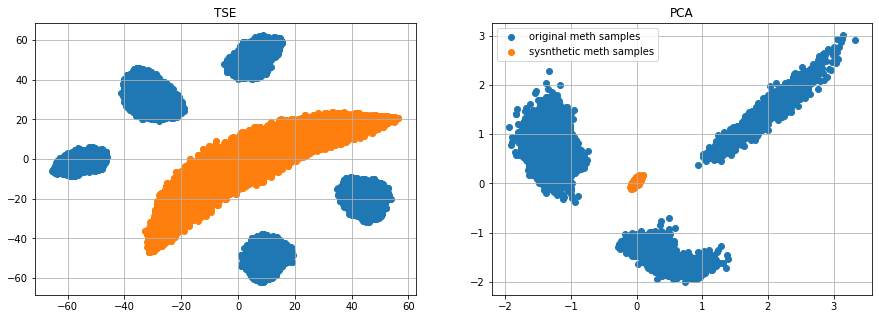

In [ ]:
# Perform the domain translation using the encoder for mRNA and the decoder for meth samples.
mrna_to_meth = VariationalAutoencoder(encoder=encoder_mrna, decoder=decoder_meth, beta=0.1)

loss =  tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
metrics = tf.keras.metrics.MeanSquaredError()
mrna_to_meth.compile(loss=loss, optimizer=optimizer, metrics=metrics)

new_mrna_samples = mrna_to_meth.predict(mrna_ds)

all_samples = np.concatenate([meth_df.values, new_mrna_samples], axis=0)
tse = TSNE(n_components=2)
all_samples_tsne = tsne.fit_transform(all_samples)

all_samples = np.concatenate([meth_df.values, new_mrna_samples], axis=0)
pca = PCA(n_components=2)
all_samples_pca = pca.fit_transform(all_samples)

figs, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(all_samples_tsne[:5000, 0], all_samples_tsne[:5000, 1], label='original meth samples')
axs[0].scatter(all_samples_tsne[5000:, 0], all_samples_tsne[5000:, 1], label='sysnthetic meth samples')
axs[0].set_title('TSE')
axs[0].grid()
axs[1].scatter(all_samples_pca[:5000, 0], all_samples_pca[:5000, 1], label='original meth samples')
axs[1].scatter(all_samples_pca[5000:, 0], all_samples_pca[5000:, 1], label='sysnthetic meth samples')
axs[1].set_title('PCA')
axs[1].grid()
plt.legend()
plt.show()
